# Libraries and function

In [37]:
import numpy as np
import pandas as pd
import pyBigWig as bw
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import sys
sys.path.insert(0, '/home/jbreda/PROseq/scripts/Phase_to_LabColor')
from phase_to_labcolor import phase_to_labcolor as p2lc

import threading
print(threading.active_count(), 'threads active at start')

from multiprocessing import Pool

import h5py

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from KalmanFilter import KalmanFilter, KalmanFilter_k_hidden

def get_gtf(infile):

    # Read gtf file
    gtf = pd.read_csv(infile,sep='\t',header=None)
    gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
    gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')
    N_gene = gtf.shape[0]

    # fix gene duplicates
    dup = gtf.gene_name.value_counts()
    my_genes = dup[dup>1].index
    for g in my_genes:
        idx = gtf[gtf.gene_name==g].index
        same_chr = (gtf.loc[idx,['chr','strand']].nunique().values == 1).all()
        overlap =  gtf.loc[idx,'end'].max() - gtf.loc[idx,'start'].min() < (gtf.loc[idx,'end'].values - gtf.loc[idx,'start'].values).sum()*2
        #gtf.loc[idx,['start']].values.max() < gtf.loc[idx,['end']].values.min()
        if same_chr and overlap:

            gtf.loc[idx[0],'start'] = gtf.loc[idx,'start'].min()
            gtf.loc[idx[0],'end'] = gtf.loc[idx,'end'].max()
            gtf.drop(idx[1:],inplace=True)
            
        else:
            print(g)
            gtf.loc[idx,'gene_name'] = [f'{g}_{i}' for i in range(len(idx))]
    gtf.set_index('gene_name',inplace=True,drop=True)

    return gtf

def get_data(coord, bw_folder, bin_size,fill_empty_bin=True):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}
    [chr,start,end,strand] = coord.split(':')
    start = int(start)
    end = int(end)

    # Load bigWigs to dataframe
    df = pd.DataFrame(columns=['start','end'])
    for t in T:
        # sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001' Run 1
        sample = f'CT{t:02d}'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        with bw.open(fin,'r') as bw_file:
            df_t = pd.DataFrame(bw_file.intervals(chr,start,end),columns=['start','end',f"{t}"])
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df.sort_values('start',inplace=True)
    df.reset_index(inplace=True,drop=True)

    # replace start and end with position in the middle of the bin, and set as index
    df['start'] = ( df.start.values + bin_size/2 ).astype(int) # bp
    df.rename(columns={'start':'pos'},inplace=True)
    df.drop('end',axis=1,inplace=True)
    df.set_index('pos',inplace=True)

    # fill empty bins with 0
    if fill_empty_bin:
        start_bin = start//bin_size*bin_size + int(bin_size/2)
        end_bin = int(np.ceil(end/bin_size)*bin_size) - int(bin_size/2)
        x = np.arange(start_bin, end_bin+1, bin_size)
        positions = df.index.values
        missing_pos = np.setdiff1d(x,positions)
        missing = pd.DataFrame(np.zeros((missing_pos.shape[0],df.shape[1])),index=missing_pos,columns=df.columns)
        df = pd.concat([df,missing],axis=0)
        df.sort_index(inplace=True)
        
    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log2(x+1),axis=1)

    return df

def get_count_per_kb(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}
    [chr,start,end,strand] = coord.split(':')

    # Load bigWigs
    count_per_kb = 0
    for t in T:
        # sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001' Run 1
        sample = f'CT{t:02d}'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        
        with bw.open(fin,'r') as bw_file:
            ints = bw_file.intervals(chr,int(start),int(end))
            if ints is None:
                continue
            count_per_kb += sum([i[2] for i in ints])
    
    count_per_kb /= (int(end) - int(start))*1e-3

    return count_per_kb

def plot_gene():
    print('ok')


8 threads active at start
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [29]:
bin_size = 1000 # bin size

T = np.arange(0,48,4) # time points
P = 24 # period
ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state
dx = bin_size # distance between positions

# observation model: inverse fourier transform
H = np.zeros((m,n))
H[:,0] = np.cos(ω*T)
H[:,1] = -np.sin(ω*T)
H /= 6

# get overall phase and amplitude
df_overall = pd.read_csv(f'../results/phase_amp/overall_phase_amp_1000bp.csv',index_col=0,sep='\t')
r_genome = df_overall.amplitude.values
φ_genome = df_overall.phase.values
a_genome = r_genome * np.cos(φ_genome)
b_genome = r_genome * np.sin(φ_genome)
μ_genome = a_genome + 1j*b_genome

del df_overall, r_genome, φ_genome, a_genome, b_genome

# get gene phase and amplitude perbin for each gene
outfile = f'../results/kalman/gene_phase_amp_Kalman_{bin_size}bp.csv'
if not os.path.exists(outfile):
    bw_folder = '../results/binned_norm_coverage'

    file_gtf = '../resources/genome/GRCm39/gene_protein_coding.gtf'
    gtf = get_gtf(file_gtf)

    #hf = h5py.File(infile_kalman_on_genes, 'r')
    infile_kalman_on_genes = f'../results/kalman/Gene_Q_1e-3/Kalman_Smoothing_{bin_size}bp.hdf5'
    with h5py.File(infile_kalman_on_genes, 'r') as hf:
        K = hf['K'][:]

        Genes = list(hf.keys())
        Genes.remove('K')
        Genes = np.array(Genes)
        LL = np.zeros((len(K),len(Genes)))
        R2 = np.zeros(len(Genes))
        strand = np.zeros(len(Genes),dtype=int)
        for g, gene in enumerate(Genes):
            LL[:,g] = hf[gene]['LL'][:]
            X = hf[gene]['measurements'][:]
            smoothed = hf[gene]['smoothed'][:]
            R2[g] =  1 - np.nansum( ((X.flatten() - smoothed.flatten())**2) )/np.nansum( (X.flatten() - np.nanmean(X))**2 )

            strand[g] = (1 if gtf.at[gene,'strand'] == '+' else -1)

    # get dataframe
    df = gtf.copy()
    df = df.loc[Genes,:]
    df['Length'] = df.end - df.start
    df['K_max'] = K[np.argmax(LL,axis=0)]
    df['speed_max'] = -1/( df['K_max'] * (P*3600)/(2*np.pi) )
    df['lambda_max_kb'] = (2*np.pi/df.K_max)*1e-3
    df['LL_ratio'] = (LL.max(axis=0,keepdims=True) - LL[K==0,:])[0,:]/np.log(2)
    df['LL_max'] = LL.max(axis=0)
    df['R2'] = R2
    df['strand'] = strand

    # get 95% confidence interval and interquantile range
    likelihood = LL - LL.max(axis=0,keepdims=True)
    p = np.exp(likelihood)/np.exp(likelihood).sum(axis=0,keepdims=True)
    K_95_low = K[np.argmin( np.abs(np.cumsum(p,0)-0.025), axis=0)]
    K_95_high = K[np.argmin( np.abs(np.cumsum(p,0)-0.975), axis=0)]
    K_25 = K[np.argmin( np.abs(np.cumsum(p,0)-0.25), axis=0)]
    K_75 = K[np.argmin( np.abs(np.cumsum(p,0)-0.75), axis=0)]
    K_median = K[np.argmin( np.abs(np.cumsum(p,0)-0.5), axis=0)]

    K_all = np.vstack((K_95_low,K_25,K_median,K_75,K_95_high)).T

    df['K_range'] = K_all.tolist()

    df['Count_per_kp'] = np.zeros(len(Genes))
    for gene in Genes:
        coord = f"{gtf.at[gene,'chr']}:{gtf.at[gene,'start']}:{gtf.at[gene,'end']}:{gtf.at[gene,'strand']}"
        df.at[gene,'Count_per_kb'] = get_count_per_kb(coord, bw_folder, bin_size)

    # get gene phase and amplitude
    gene_phase_amp = pd.read_csv(f'../results/phase_amp/gene_phase_amp.csv',index_col=-1,sep='\t')

    # remove duplicate index
    dup = gene_phase_amp.index.value_counts()
    dup = dup[dup > 1]
    for g in dup.index:
        tmp = gene_phase_amp.loc[g,:]
        idx = tmp[tmp.pval == tmp.pval.min()]
        idx = np.where(  (tmp.pval == tmp.pval.min()).values )[0][0]

        gene_phase_amp.drop(index=g, inplace=True)
        gene_phase_amp.loc[g,:] = tmp.iloc[idx,:]

    df['pval'] = gene_phase_amp.loc[df.index,'pval']


    # flip LL for reverse genes
    for g in df.index[df.strand==-1]:
        LL[:,df.index==g] = LL[::-1,df.index==g]

    # Take log10 of some columns and rename
    df.pval = np.log10(df.pval)
    df.Length = np.log10(df.Length)
    df.Count_per_kb = np.log10(df.Count_per_kb)
    df.rename(columns={'Length':'log10 Length','Count_per_kb':'log10 Count_per_kb','pval':'log10 pval'},inplace=True)

    df.to_csv(outfile,sep='\t',index=True)
else:
    df = pd.read_csv(outfile,index_col=0,sep='\t')

# Scatter Plot Kalman smoothing

/tmp/ipykernel_34708/782232803.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)
/tmp/ipykernel_34708/782232803.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)
/tmp/ipykernel_34708/782232803.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)


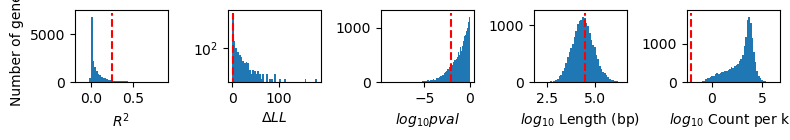

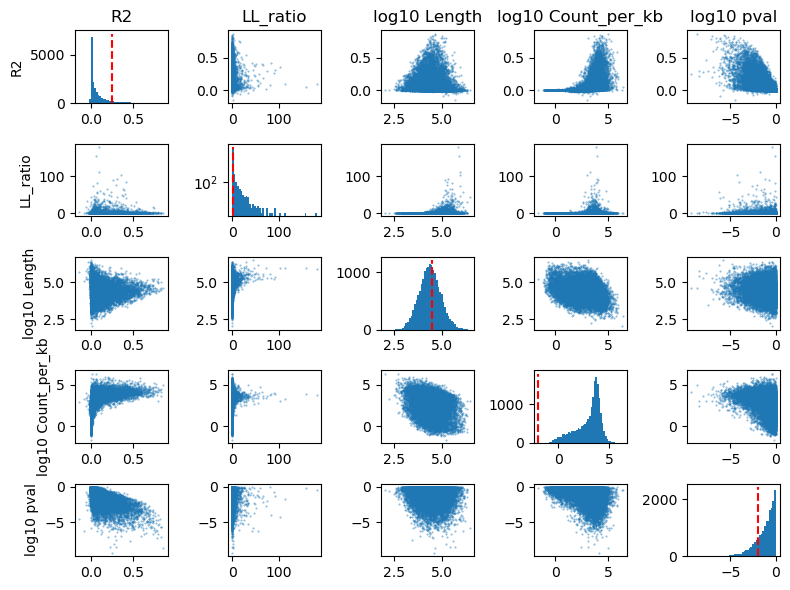

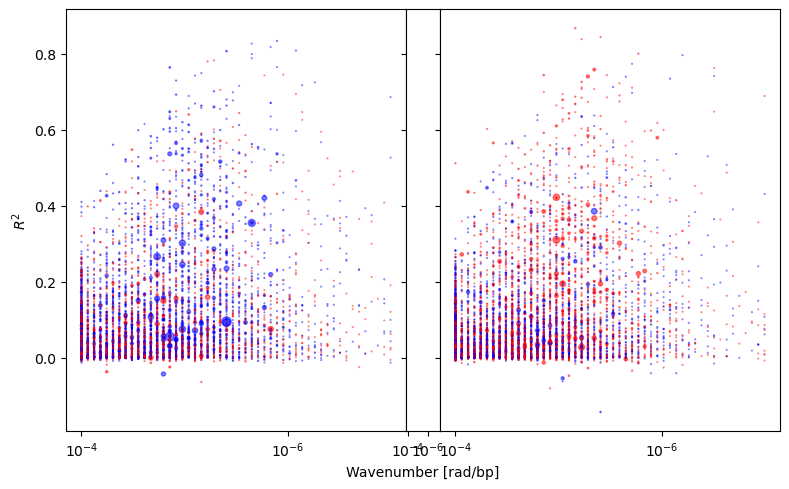

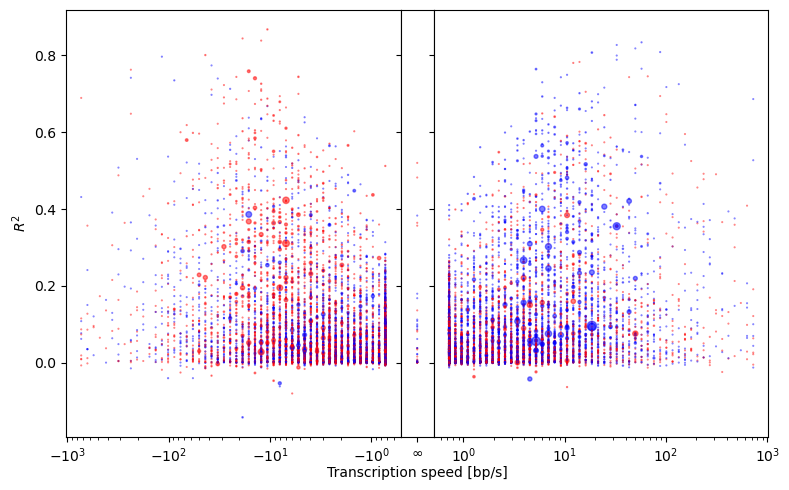

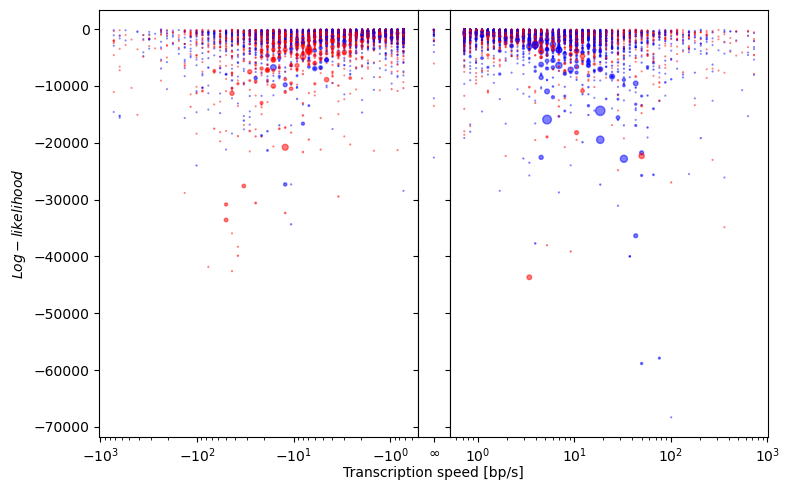

In [30]:
th = {}
th['R2'] = 0.25
th['LL_ratio'] = 2
th['log10 Length'] = np.log10(3e4)
th['log10 Count_per_kb'] = -2
th['log10 pval'] = -2

# plot distribution of R2, LL_ratio, log10 Length, log10 Count_per_kb, log10 pval
fig, axes = plt.subplots(1, 5, figsize=(8, 1.5))
ax = axes[0]
ax.hist(df['R2'],bins=50)
ax.plot([th['R2'],th['R2']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$R^2$')
ax.set_ylabel('Number of genes')
ax = axes[1]
ax.hist(df['LL_ratio'],bins=50)
ax.plot([th['LL_ratio'],th['LL_ratio']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$\Delta LL$')
ax.set_yscale('log')
ax = axes[2]
ax.hist(df['log10 pval'],bins=101)
ax.plot([th['log10 pval'],th['log10 pval']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$log_{10} pval$')
ax = axes[3]
ax.hist(df['log10 Length'],bins=50)
ax.set_xlabel(r'$log_{10}$ Length (bp)')
ax.plot([th['log10 Length'],th['log10 Length']],[0,ax.get_ylim()[1]],'r--')
ax = axes[4]
ax.hist(df['log10 Count_per_kb'][~np.isinf(df['log10 Count_per_kb'])],bins=50)
ax.plot([th['log10 Count_per_kb'],th['log10 Count_per_kb']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$log_{10}$ Count per kb')


fig.tight_layout()
fig.savefig('fig/kalman/Histogram_R2_LLratio_pval_Len_Count.pdf',bbox_inches='tight')

# scatter plot with every pair of variables
fig, axes = plt.subplots(5, 5, figsize=(8,6))
for i, var1 in enumerate(['R2','LL_ratio','log10 Length','log10 Count_per_kb','log10 pval']):
    for j, var2 in enumerate(['R2','LL_ratio','log10 Length','log10 Count_per_kb','log10 pval']):
        ax = axes[i,j]
        if i==j:
            if var1 == 'log10 Count_per_kb':
                ax.hist(df[var1][~np.isinf(df[var1])],bins=50)
            else:
                ax.hist(df[var1],bins=50)
            ax.plot([th[var1],th[var1]],[0,ax.get_ylim()[1]],'r--')
            if var1 == 'LL_ratio':
                ax.set_yscale('log')
        else:
            ax.scatter(df[var2],df[var1],marker='.',s=1,alpha=.5)
        
        if i==(len(var1)-1):
            ax.set_xlabel(var2)
        if i == 0:
            ax.set_title(var2)
        if j==0:
            ax.set_ylabel(var1)
fig.tight_layout()
            


# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8, 5))

# plot
sign = np.sign(df.K_max)
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df.K_max) == k_sign)
    if k_sign == -1:
        x = -df.loc[idx,'K_max']
        
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
        ax.invert_xaxis()
    elif k_sign == 0:
        x = df.loc[idx,'K_max']
        ax.set_xlabel('Wavenumber [rad/bp]')
        ax.set_xticks([0],['0'])
    elif k_sign == 1:
        x = df.loc[idx,'K_max']
        ax.set_xscale('log')

    #ax.scatter(x=x,y=df.loc[idx,'R2'],marker='.',s=10*-np.log10(df.loc[idx,'pval'])+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    ax.scatter(x=x,y=df.loc[idx,'R2'],marker='.',s=df.loc[idx,'LL_ratio']+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    
    if k_sign==-1:
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Kmax_R2_LLratio_strand.pdf',bbox_inches='tight')



# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,5))

# plot
sign = np.sign(df.speed_max)
sign[np.isinf(df.speed_max)] = 0
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df.speed_max) == k_sign)
    if k_sign == -1:
        x = -df.loc[idx,'speed_max']
        ax.invert_xaxis()
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
    elif k_sign == 0:
        x = np.sum(sign==0)*[0]
        ax.set_xlim(-1,1)
        ax.set_xticks([0],[r'$\infty$'])
        ax.set_xlabel('Transcription speed [bp/s]')
        idx = np.isinf(df.speed_max)
    elif k_sign == 1:
        x = df.loc[idx,'speed_max']
        ax.set_xscale('log')

    ax.scatter(x=x,y=df.loc[idx,'R2'],marker='.',s=df.loc[idx,'LL_ratio']+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    
    if k_sign==-1:
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_speedmax_R2_LLratio_strand.pdf',bbox_inches='tight')


# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,5))

# plot
sign = np.sign(df.speed_max)
sign[np.isinf(df.speed_max)] = 0
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df.speed_max) == k_sign)
    if k_sign == -1:
        x = -df.loc[idx,'speed_max']
        ax.invert_xaxis()
        ax.set_ylabel(r'$Log-likelihood$')
        ax.set_xscale('log')
    elif k_sign == 0:
        x = np.sum(sign==0)*[0]
        ax.set_xlim(-1,1)
        ax.set_xticks([0],[r'$\infty$'])
        ax.set_xlabel('Transcription speed [bp/s]')
        idx = np.isinf(df.speed_max)
    elif k_sign == 1:
        x = df.loc[idx,'speed_max']
        ax.set_xscale('log')

    ax.scatter(x=x,y=df.loc[idx,'LL_max'],marker='.',s=df.loc[idx,'LL_ratio']+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    
    if k_sign==-1:
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_speedmax_LLmax_LLratio_strand.pdf',bbox_inches='tight')

4026


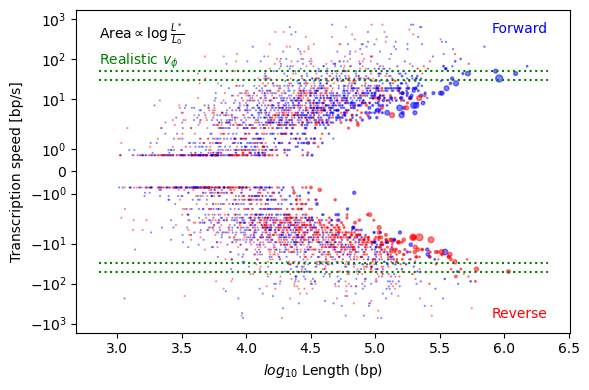

In [31]:
# Thresholds
th = {}
th['R2'] = 0.1
th['LL_ratio'] = -np.inf
th['log10 Length'] = np.log10(1e3)
th['log10 Count_per_kb'] = -1
th['log10 pval'] = -1


idx_top = (df['R2'] >= th['R2']) & (df['LL_ratio'] >= th['LL_ratio']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 Count_per_kb'] >= th['log10 Count_per_kb']) & (df['log10 pval'] <= th['log10 pval'])

print(idx_top.sum())

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.scatter(x=df.loc[idx_top,'log10 Length'],y=df.loc[idx_top,'speed_max'],s=(df.loc[idx_top,'LL_ratio']+1),c=df.loc[idx_top,'strand'],cmap='bwr_r',marker='.',alpha=.5)
ax.set_yscale('symlog')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([xlim[0],xlim[1]],[30,30],'g:')
ax.plot([xlim[0],xlim[1]],[50,50],'g:')
ax.plot([xlim[0],xlim[1]],[-30,-30],'g:')
ax.plot([xlim[0],xlim[1]],[-50,-50],'g:')
ax.set_xlabel(r'$log_{10}$ Length (bp)')
ax.set_ylabel('Transcription speed [bp/s]')

ax.text(xlim[1], .5*ylim[1], 'Forward', fontsize=10, color='b', horizontalalignment='right', verticalalignment='top')
ax.text(xlim[1], .5*ylim[0], 'Reverse', fontsize=10, color='r', horizontalalignment='right', verticalalignment='bottom')
ax.text(xlim[0], .5*ylim[1], r'Area$\propto\log \frac{L^*}{L_0}$', fontsize=10, color='k', horizontalalignment='left', verticalalignment='top')
ax.text(xlim[0], 50, r'Realistic $v_\phi$', fontsize=10, color='g', horizontalalignment='left', verticalalignment='bottom')

fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Length_speedmax_LLmax_strand.pdf',bbox_inches='tight')


182


/tmp/ipykernel_34708/2372149646.py:16: RuntimeWarning: invalid value encountered in divide
  p = np.exp(likelihood)/np.exp(likelihood).sum(axis=0,keepdims=True)
/tmp/ipykernel_34708/2372149646.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i],df_top.loc[g,'R2'],g,fontsize=8,ha='center',va='bottom')
/tmp/ipykernel_34708/2372149646.py:32: RuntimeWarning: invalid value encountered in scalar divide
  f_forward = (df_top.loc[idx,'strand'] == 1).sum()/idx.sum()
/tmp/ipykernel_34708/2372149646.py:33: RuntimeWarning: invalid value encountered in scalar divide
  f_reverse = (df_top.loc[idx,'strand'] == -1).sum()/idx.sum()
/tmp/ipykernel_34708/2372149646.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

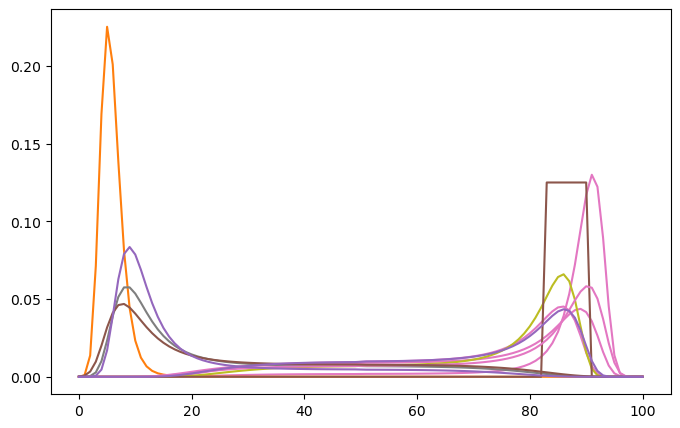

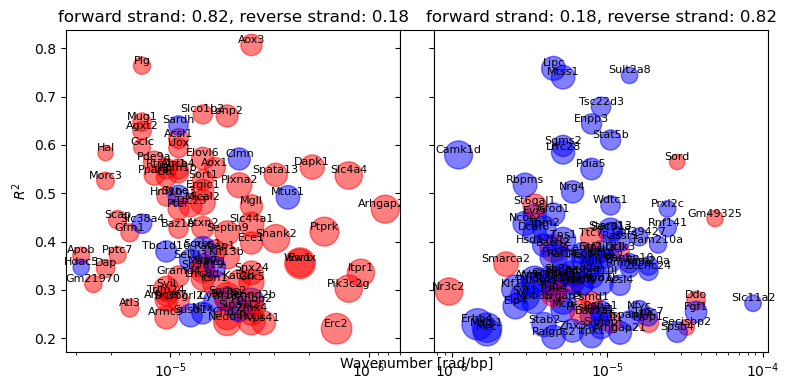

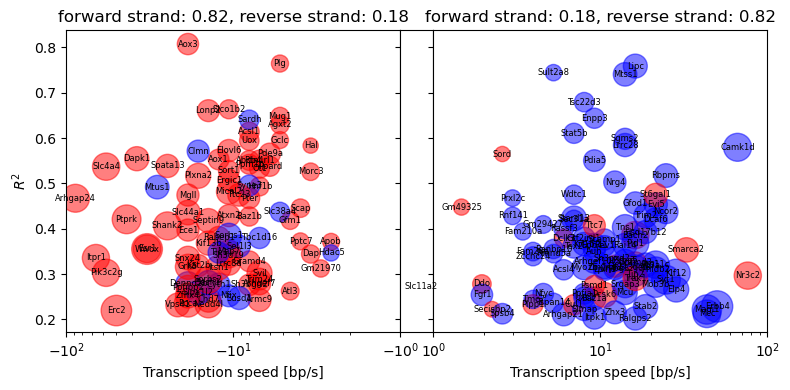

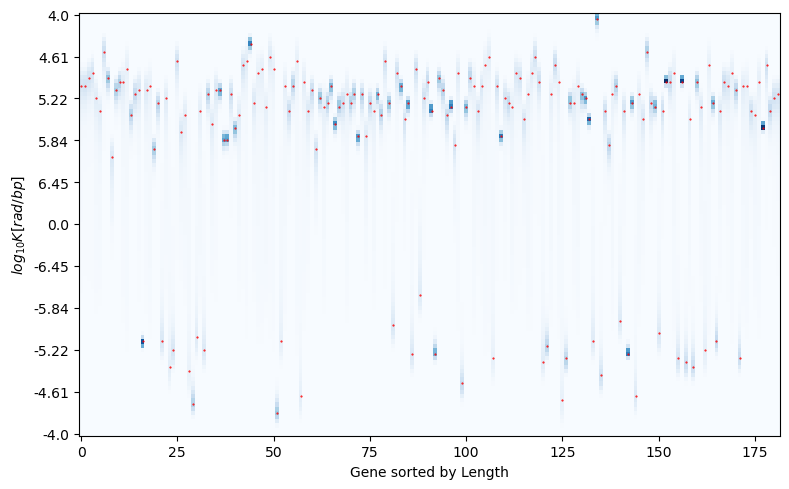

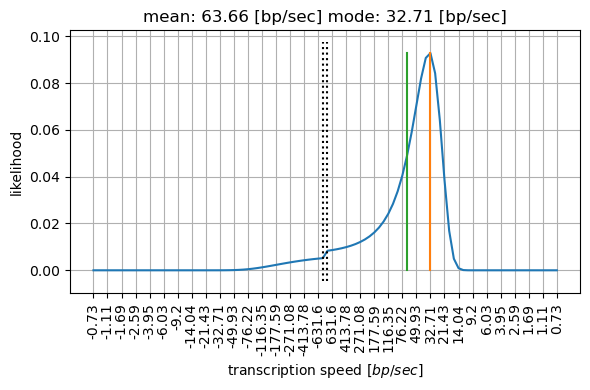

In [33]:
# Thresholds
th = {}
th['R2'] = 0.2
th['LL_ratio'] = 2
th['log10 Length'] = np.log10(3e4)
th['log10 Count_per_kb'] = -1
th['log10 pval'] = -2


idx_top = (df['R2'] >= th['R2']) & (df['LL_ratio'] >= th['LL_ratio']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 Count_per_kb'] >= th['log10 Count_per_kb']) & (df['log10 pval'] <= th['log10 pval'])

print(idx_top.sum())
df_top = df.loc[idx_top,:]

likelihood = LL[:,idx_top]
p = np.exp(likelihood)/np.exp(likelihood).sum(axis=0,keepdims=True)
K_low = K[np.argmin( np.abs(np.cumsum(p,0)-0.05), axis=0)]
K_high = K[np.argmin( np.abs(np.cumsum(p,0)-0.95), axis=0)]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(101),p)


# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1,3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,4))

# plot
sign = np.sign(df_top.K_max)
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df_top.K_max) == k_sign)
    f_forward = (df_top.loc[idx,'strand'] == 1).sum()/idx.sum()
    f_reverse = (df_top.loc[idx,'strand'] == -1).sum()/idx.sum()
    if k_sign == -1:
        x = -df_top.loc[idx,'K_max']
        ax.invert_xaxis()
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
    elif k_sign == 0:
        x = df_top.loc[idx,'K_max']
        ax.set_xlabel('Wavenumber [rad/bp]')
        ax.set_xticks([],[])
    elif k_sign == 1:
        x = df_top.loc[idx,'K_max']
        ax.set_xscale('log')
        
    
    if idx.sum() > 0:
        ax.set_title(f'forward strand: {f_forward:.2f}, reverse strand: {f_reverse:.2f}')
        ax.scatter(x=x,y=df_top.loc[idx,'R2'],marker='.',s=1000*(df_top.loc[idx,'log10 Length']-4),c=df_top.loc[idx,'strand'],cmap='bwr',alpha=.5 )
        for i,g in enumerate(df_top.loc[idx,:].index):
            ax.text(x[i],df_top.loc[g,'R2'],g,fontsize=8,ha='center',va='bottom')


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Kmax_R2_LLratio_strand_top_genes.pdf',bbox_inches='tight')




# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1,3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,4))

# plot
sign = np.sign(df_top.speed_max)
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df_top.K_max) == k_sign)
    f_forward = (df_top.loc[idx,'strand'] == 1).sum()/idx.sum()
    f_reverse = (df_top.loc[idx,'strand'] == -1).sum()/idx.sum()
    if k_sign == -1:
        x = df_top.loc[idx,'speed_max']
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
        ax.set_xlim(1,100)
        ax.set_xlabel('Transcription speed [bp/s]')
        ax.invert_xaxis()
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)
    elif k_sign == 0:
        x = df_top.loc[idx,'speed_max']
        #ax.set_xlabel('Transcription speed [bp/s]')
        ax.set_xticks([],[])
    elif k_sign == 1:
        x = -df_top.loc[idx,'speed_max']
        ax.set_xscale('log')
        ax.set_xlim(1,100)
        ax.set_xlabel('Transcription speed [bp/s]')

        
    
    if idx.sum() > 0:
        ax.set_title(f'forward strand: {f_forward:.2f}, reverse strand: {f_reverse:.2f}')
        ax.scatter(x=x,y=df_top.loc[idx,'R2'],marker='.',s=1000*(df_top.loc[idx,'log10 Length']-4),c=df_top.loc[idx,'strand'],cmap='bwr',alpha=.5 )
        for i,g in enumerate(df_top.loc[idx,:].index):
            ax.text(x[i],df_top.loc[g,'R2'],g,fontsize=6,ha='center',va='center')


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Speedmax_R2_LLratio_strand_top_genes.pdf',bbox_inches='tight')



p = np.exp(LL[:,idx_top]-LL[:,idx_top].max(0,keepdims=True))
p /= p.sum(0,keepdims=True)
strand = np.sign(df.strand[idx_top])
Length = df['log10 Length'][idx_top]
#Count_per_kb = df.Count_per_kb[idx_top]
Max_LL = df.LL_max[idx_top]

Λ = 2*np.pi/K

LL_k = LL[:,idx_top].mean(1)
LL_k = LL_k - LL_k.max()
P_k = np.exp(LL_k)
P_k /= P_k.sum()
speed_bp_per_s = -1/(K/(2*np.pi) *P*3600)
P_k = P_k[~np.isinf(speed_bp_per_s)]
speed_bp_per_s = speed_bp_per_s[~np.isinf(speed_bp_per_s)]
mean_speed = np.sign(np.sum(speed_bp_per_s)) * np.exp( np.sum(np.log(abs(speed_bp_per_s))*P_k)/np.sum(P_k) )
mode_speed = speed_bp_per_s[np.argmax(P_k)]

mean_speed_pos = np.argmin(abs(speed_bp_per_s - mean_speed))

fig, ax = plt.subplots(1,1,figsize=(8,5))

h = ax.imshow(p,cmap='Blues',origin='lower',aspect='auto',interpolation='none')
# plot max
x = range(p.shape[1])
y = np.argmax(p,0)
ax.plot(x,y,'r.',markersize=1)
ax.set_xlabel(r'Gene sorted by Length')
ax.set_ylabel(r'$log_{10} K [rad/bp]$')
y_ticks = range(0,p.shape[0],10)
y_ticklabels = np.round(np.sign(K[y_ticks])*np.log10( np.abs(K[y_ticks]) ),2)
y_ticklabels[np.isnan(y_ticklabels)] = 0
ax.set_yticks(y_ticks,y_ticklabels)
fig.tight_layout()
#fig.savefig(out_ll_plot,bbox_inches='tight')

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(range(len(P_k)),P_k)
ax.plot(2*[np.argmax(P_k)],[0,P_k.max()],'-')
ax.plot(2*[mean_speed_pos],[0,P_k.max()],'-')

x_ticks = range(0,len(P_k),3)
x_ticklabels = np.round(speed_bp_per_s[x_ticks],2)
x_ticklabels[np.isnan(x_ticklabels)] = 0
ax.set_xticks(x_ticks,x_ticklabels,rotation=90)
ax.grid()
ax.set_xlabel(r'transcription speed $[bp/sec]$')
ax.set_ylabel(r'likelihood')
ax.set_title(r'mean: {:.2f} [bp/sec] mode: {:.2f} [bp/sec]'.format(mean_speed,mode_speed))

y = ax.get_ylim()
x = np.where(speed_bp_per_s==speed_bp_per_s.min())[0]
ax.plot(2*[x],y,'k:')
x = np.where(speed_bp_per_s==speed_bp_per_s.max())[0]
ax.plot(2*[x],y,'k:')

fig.tight_layout()
fig.savefig('fig/kalman/phase_velocity_likelihood.pdf',bbox_inches='tight')

## Publications on transcription rate in mouse
* Bahar Halpern K. et al., Bursty gene expression in the intact mammalian liver. Mol Cell. 2015 Apr 2 58(1):147-56. doi: 10.1016/j.molcel.2015.01.027.
* Mouse Liver polymerase speed: 34 ± 11 bp/s
* "Using intensity ratios of probe libraries targeting both ends of the gene, [investigators] demonstrated that >85% of nascent mRNAs at TSs [transcription sites] are attached to actively transcribing polymerase molecules (Figure S3). Thus, the number of nascent mRNA can be used as a proxy for polymerase occupancy (M). [They] next used polymerase occupancy to infer the transcription rate μ, the average rate of mRNA production from an active TS, using the equation μ=M⋅v/L, where L is the length of the gene and v = 34 ± 11 bp/s is the polymerase speed, which [they] calibrated using actinomycin D treatment (Experimental Procedures)."

* Jonkers I, Kwak H, Lis JT. Genome-wide dynamics of Pol II elongation and its interplay with promoter proximal pausing, chromatin, and exons. Elife. 2014 Apr 29 3: e02407. doi: 10.7554/eLife.02407.
* Mouse liver Pol II Elongation rate: 1.8 - 14.4 bp/sec
* "[Researchers] measured elongation rates ranging from 0.5 to 4 kb/min at ~1000 genes and within different regions of genes. Strikingly, Pol II accelerates as it transcribes through the gene body, and a large amount of variation in elongation rates occurs between genes, and is associated with chromatin and exon density."

965


/tmp/ipykernel_34708/3457201211.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_top['speed_max'][df_top['strand']==-1] *= -1
/tmp/ipykernel_34708/3457201211.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

ValueError: Can only output finite numbers in PDF

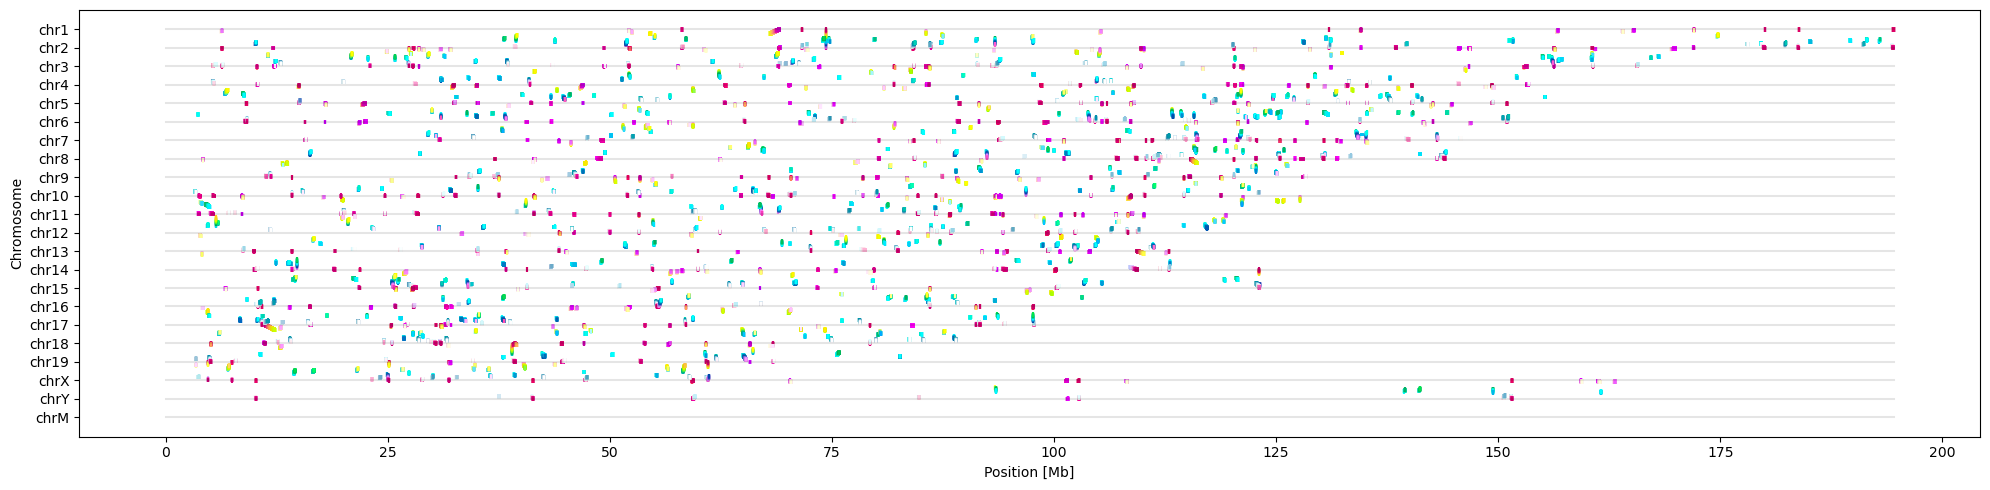

In [44]:
# Thresholds
th = {}
th['R2'] = 0.1
th['LL_ratio'] = 0.1
th['log10 Length'] = np.log10(4e4)
th['log10 Count_per_kb'] = -1
th['log10 pval'] = -1

idx_top = (df['R2'] >= th['R2']) & (df['LL_ratio'] >= th['LL_ratio']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 Count_per_kb'] >= th['log10 Count_per_kb']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())

df_top = df.loc[idx_top,:]
df_top['speed_max'][df_top['strand']==-1] *= -1

if True:
    CHR = np.array( [f'chr{c+1}' for c in range(19)] + ['chrX','chrY','chrM'] )

    X = np.array([])
    Y = np.array([])
    C = np.zeros((0,3))
    hf =  h5py.File(infile_kalman_on_genes, 'r')

    for g, gene in enumerate( df_top.index ):
        chr = np.where(df_top.loc[gene,'chr'] == CHR)[0]
        x = hf[gene]['positions'][:]
        y = np.ones(len(x))*chr

        μ_tT = hf[gene]['mu'][:].T
        μ_tT = μ_tT[0,:] + 1j*μ_tT[1,:]
        μ_tT -= μ_genome
        φ_kf = -np.arctan2(np.imag(μ_tT),np.real(μ_tT))
        φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

        h = φ_kf/(2*np.pi)
        c = p2lc(φ_kf)

        X = np.concatenate([X,x])
        Y = np.concatenate([Y,y+h],axis=0)
        C = np.concatenate([C,c],axis=0)

    hf.close()

    fig, ax = plt.subplots(1,1,figsize=(20,5))

    for i in range(len(CHR)):
        ax.plot([0,X.max()*1e-6],[i,i],'k-',alpha=.1)
    ax.scatter(x=X*1e-6,y=Y,c=C,s=10,marker='|',alpha=1)
    ax.set_yticks(range(len(CHR)),CHR)
    ax.set_ylabel('Chromosome')
    ax.set_xlabel('Position [Mb]')
    # flip axis
    ax.invert_yaxis()
    fig.tight_layout()
    fig.savefig(f'fig/kalman/Phase_position_top_genes.pdf',bbox_inches='tight')


th = {}
th['R2'] = 0.1
th['LL_ratio'] = 0
th['log10 Length'] = np.log10(1e4)
th['log10 Count_per_kb'] = -3
th['log10 pval'] = -1

idx_top = (df['R2'] >= th['R2']) & (df['LL_ratio'] >= th['LL_ratio']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 Count_per_kb'] >= th['log10 Count_per_kb']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())




        

ValueError: Can only output finite numbers in PDF

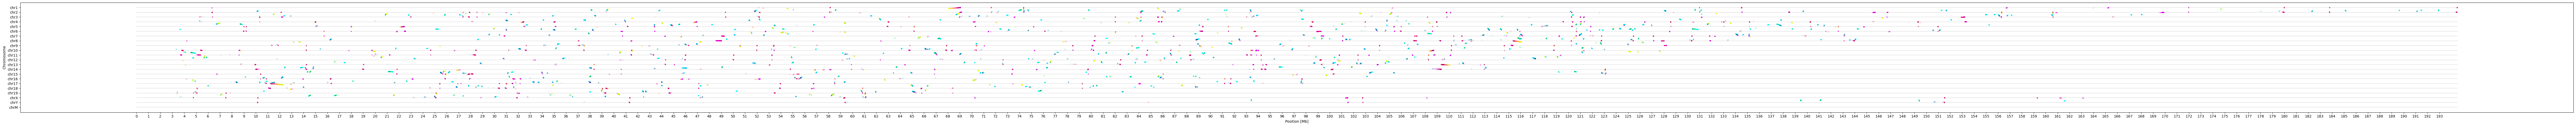

In [47]:
fig, ax = plt.subplots(1,1,figsize=(100,5))

for i in range(len(CHR)):
    ax.plot([0,X.max()*1e-6],[i,i],'k-',alpha=.1)
ax.scatter(x=X*1e-6,y=Y,c=C,s=10,marker='|',alpha=1)
ax.set_yticks(range(len(CHR)),CHR)
ax.set_xticks(range(0,int(X.max()*1e-6)))
ax.set_ylabel('Chromosome')
ax.set_xlabel('Position [Mb]')

# flip axis
ax.invert_yaxis()
fig.tight_layout()
fig.savefig(f'fig/kalman/Phase_position_top_genes.pdf',dpi=300,bbox_inches='tight')

# Plot per gene

3057
Erbb4


/tmp/ipykernel_34708/4144919489.py:43: RuntimeWarning: Degrees of freedom <= 0 for slice.
  sig2_res = np.nanvar(X - x_hat,0)
/tmp/ipykernel_34708/4144919489.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice.
  sig2_tot = np.nanvar(X,0)


ValueError: Can only output finite numbers in PDF

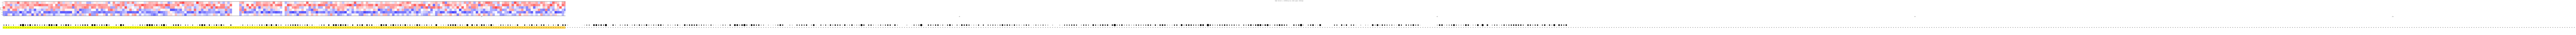

In [51]:
th = {}
th['R2'] = 0.1
th['LL_ratio'] = -np.inf
th['log10 Length'] = 4
th['log10 Count_per_kb'] = -1
th['log10 pval'] = -1

idx_top = (df['R2'] >= th['R2']) & (df['LL_ratio'] >= th['LL_ratio']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 Count_per_kb'] >= th['log10 Count_per_kb']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())

idx_top = df.index == 'Erbb4'

with h5py.File(infile_kalman_on_genes, 'r') as hf:

    for g, gene in enumerate( df.index[idx_top] ):
        
        print(gene)
        
        outfig = f'fig/kalman/top_genes/{gene}.pdf'
        if os.path.exists(outfig):
            continue

        X = hf[gene]['measurements'][:]
        n_bin = X.shape[1]
        
        # Amp and phase of fourier transform
        f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
        f_n -= μ_genome
        a_n = 4/m * np.abs(f_n)
        φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
        φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
        mu_n = 1/n_bin * np.sum(X,0)

        # phase/amp to color
        h = φ_n/(2*np.pi)
        s = a_n/np.nanmax(a_n)
        s = np.ones(n_bin)
        v = np.ones(n_bin)
        color_f = p2lc(φ_n)

        # compute fit's R2 and p-value
        x_hat = mu_n[None,:] + 0.5 * a_n[None,:] * np.cos(ω*T[:,None] - φ_n[None,:])
        sig2_res = np.nanvar(X - x_hat,0)
        sig2_tot = np.nanvar(X,0)
        R2 = np.zeros(sig2_res.shape)
        R2[sig2_tot==0] = 0
        R2[np.isnan(sig2_tot)] = 0
        R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
        R2[R2<0] = 0

        # Kalman filter
        μ_tT = hf[gene]['mu'][:].T
        Σ_tT = hf[gene]['Sigma'][:]

        # Amp and phase of kalman filter
        μ_tT = μ_tT[0,:] + 1j*μ_tT[1,:]
        μ_tT -= μ_genome
        a_kf = 4/m * np.abs(μ_tT)
        φ_kf = -np.arctan2(np.imag(μ_tT),np.real(μ_tT))
        φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

        h = φ_kf/(2*np.pi)
        s = a_kf/a_kf.mean()
        s[s>1] = 1
        v = np.ones(n_bin)
        color_kf = p2lc(φ_kf)

        # plot phase per bin
        Φ = np.ones((2,n_bin,3))
        Φ[0,:] = color_f
        Φ[1,:] = color_kf
        
        fig, axes = plt.subplots(2,1,figsize=(n_bin/2,15/2))
        ax = axes[0]

        # plot heatmap
        # normalize X columns as Z-score
        X = X[:6,:] + X[6:,:]
        X = (X - X.mean(0))/X.std(0)
        #X = np.concatenate([X[3:,:],X,X[:3,:]],axis=0)
        ax.set_title(rf'{gene} - R2={df.at[gene,"R2"]:.2f} - L = {10**(df.at[gene,"log10 Length"]):.0f} bp - $\Delta$LL = {df.at[gene,"LL_ratio"]:.2f} - speed = {df.at[gene,"speed_max"]:.2f} bp/s')

        ax.imshow(X,aspect='equal',interpolation='none',cmap='bwr',vmin=-3,vmax=3)
        ax.set_yticks(range(6),['0','4','8','12','16','20'])
        ax.set_ylabel('Time [h]')
        
        #fig.tight_layout()
        #fig.savefig(f'fig/kalman/top_genes/{gene}_heatmap.pdf',bbox_inches='tight')


        #fig, ax = plt.subplots(1,1,figsize=(n_bin,3))
        ax = axes[1]
        
        plt.axis('off')
        
        ax.imshow(color_kf[None,:],aspect='equal',interpolation='none')
        for i,c in enumerate(color_f):
            cir = plt.Circle((i, 1), R2[i]/2, color=c,fill=True)
            ax.add_patch(cir)
            if df.at[gene,'strand'] == 1:
                ax.text(i,0,'>',ha='center',va='center',fontsize=20)
            else:
                ax.text(i,0,'<',ha='center',va='center',fontsize=20)
        ax.set_aspect('equal', adjustable='datalim')
        ax.set_ylim([-0.5,1.5])
        
        ax.set_xlabel('Position rel. to tss [kb]')

        fig.tight_layout()
        fig.savefig(outfig,bbox_inches='tight')

        plt.close('all')
    


# Plot flanks expression anbd phase relative to gene body

In [52]:

# Thresholds
th = {}
th['R2'] = 0.2
th['LL_ratio'] = .1
th['log10 Length'] = np.log10(1e4)
th['log10 Count_per_kb'] = -2
th['log10 pval'] = -2

idx_top = (df['R2'] >= th['R2']) & (df['LL_ratio'] >= th['LL_ratio']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 Count_per_kb'] >= th['log10 Count_per_kb']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())

# get genes relative expression along its body 
hf = h5py.File(infile_kalman_on_genes, 'r')
strand_dict = {'+': 1, '-': -1, 1: '+', -1: '-'}
n_bins_flank = 100
bin_size = 100

Flank_rel_expression = {}
Flank_rel_phase = {}
for flank in ['same_up','same_down','opp_up','opp_down']:
    Flank_rel_expression[flank] = np.zeros((sum(idx_top),n_bins_flank))*np.nan
    Flank_rel_phase[flank] = np.zeros((sum(idx_top),n_bins_flank))*np.nan

def get_flank_expression_phase(gene):
    
    # get gene coordinates
    chr = gtf.at[gene,'chr']
    start = gtf.at[gene,'start']
    end = gtf.at[gene,'end']
    strand = gtf.at[gene,'strand']
    strand_opp = strand_dict[-strand_dict[strand]]

    # get gene mean expression
    X = get_data(f'{chr}:{start}:{end}:{strand}', bw_folder, bin_size)
    μ = X.values.mean()

    # get gene phase, amplitude and mean expression
    with h5py.File(infile_kalman_on_genes, 'r') as hf:
        μ_tT = hf[gene]['mu'][:].T
    μ_tT = μ_tT[0,:] + 1j*μ_tT[1,:]

    φ_start = -np.arctan2(np.imag(μ_tT[0]),np.real(μ_tT[0]))
    if φ_start<0:
        φ_start += 2*np.pi # make sure φ_n is between 0 and 2pi
    φ_end = -np.arctan2(np.imag(μ_tT[-1]),np.real(μ_tT[-1]))
    if φ_end<0:
        φ_end += 2*np.pi # make sure φ_n is between 0 and 2pi

    Flanks = {}
    Flanks['same_up'] =   get_data(f'{chr}:{start-n_bins_flank*bin_size}:{start-bin_size+1}:{strand}', bw_folder, bin_size)
    Flanks['same_down'] = get_data(f'{chr}:{end+bin_size-1}:{end+n_bins_flank*bin_size}:{strand}', bw_folder, bin_size)
    Flanks['opp_up'] =    get_data(f'{chr}:{start-n_bins_flank*bin_size}:{start-bin_size+1}:{strand_opp}', bw_folder, bin_size)
    Flanks['opp_down'] =  get_data(f'{chr}:{end+bin_size-1}:{end+n_bins_flank*bin_size}:{strand_opp}', bw_folder, bin_size)
    
    if strand == '-':
        # flip flanks
        Flanks['same_up'], Flanks['same_down'] = Flanks['same_down'], Flanks['same_up']
        Flanks['opp_up'], Flanks['opp_down'] = Flanks['opp_down'], Flanks['opp_up']
    
        # invert index order
        for flank in Flanks:
            Flanks[flank].sort_index(inplace=True,ascending=False)

    # get flanks phase
    f_flanks = {}
    φ_flanks = {}
    μ_flanks = {}
    for flank in Flanks:
        if flank in ['same_up','opp_up']:
            φ = φ_start
        elif flank in ['same_down','opp_down']:
            φ = φ_end
            
        idx_out = Flanks[flank].var(1) < 1e-10

        f_flanks[flank] = np.sum( Flanks[flank].values * np.exp(-1j*ω*T) ,1)
        f_flanks[flank][idx_out] = np.nan
        
        φ_flanks[flank] = -np.arctan2(np.imag(f_flanks[flank]),np.real(f_flanks[flank]))
        φ_flanks[flank][φ_flanks[flank]<0] += 2*np.pi
        # relative to gene phase
        φ_flanks[flank] = φ_flanks[flank] - φ
        φ_flanks[flank] = (φ_flanks[flank] + np.pi) % (2*np.pi) - np.pi
        φ_flanks[flank][idx_out] = np.nan

        μ_flanks[flank] = (Flanks[flank].values.mean(1) - μ)/np.log(2)
    
    return μ_flanks, φ_flanks

with Pool(48) as p:
    OUT = p.map(get_flank_expression_phase, Genes[idx_top])


for g,gene in enumerate(Genes[idx_top]):
    for flank in Flank_rel_expression:
        Flank_rel_expression[flank][g,:] = OUT[g][0][flank]
        Flank_rel_phase[flank][g,:] = OUT[g][1][flank]


786


/tmp/ipykernel_34708/1713968047.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,missing],axis=0)
/tmp/ipykernel_34708/1713968047.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,missing],axis=0)
/tmp/ipykernel_34708/1713968047.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain t

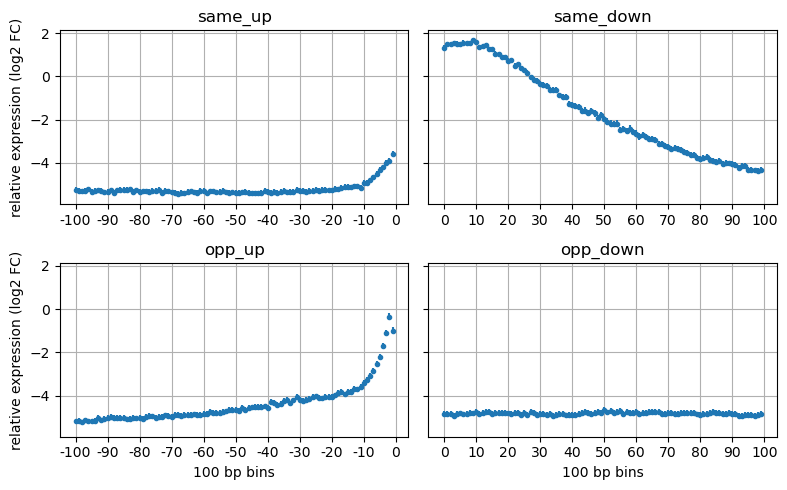

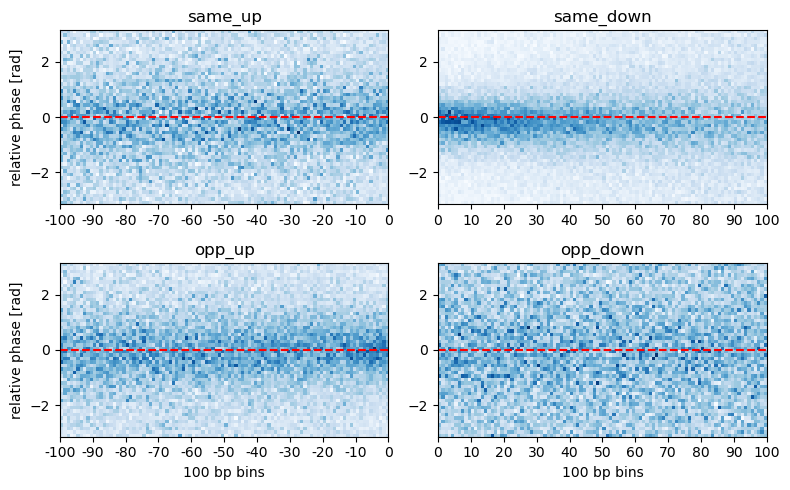

In [54]:
# plot phase and amplitude of flanks
fig, axes = plt.subplots(2, 2, figsize=(8, 5),sharey=True)
axes = axes.flatten()
for i, flank in enumerate(Flank_rel_expression):
    ax = axes[i]
    ax.errorbar(x=range(n_bins_flank),y=Flank_rel_expression[flank].mean(0),yerr=Flank_rel_expression[flank].std(0)/np.sqrt(sum(idx_top)),fmt='.')
    ax.set_title(flank)
    if flank.split('_')[0] == 'opp':
        ax.set_xlabel(f'{bin_size} bp bins')
    # if up put xtick from -bins to 0
    if flank.split('_')[1] == 'up':
        ax.set_ylabel('relative expression (log2 FC)')
        ax.set_xticks(range(0,n_bins_flank+1,10),range(-n_bins_flank,1,10))
    else:
        ax.set_xticks(range(0,n_bins_flank+1,10),range(0,n_bins_flank+1,10))

    ax.grid()
    
fig.tight_layout()
fig.savefig('fig/kalman/Flank_expression.pdf',bbox_inches='tight')

fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()
for i, flank in enumerate(Flank_rel_phase):
    ax = axes[i]
    bins = np.linspace(-np.pi,np.pi,51)

    H = np.zeros((len(bins)-1,n_bins_flank))
    for b in range(n_bins_flank):
        H[:,b] = np.histogram(Flank_rel_phase[flank][:,b],bins=bins)[0]

    H /= H.sum(0,keepdims=True)
    #H = np.log2(H)
    ax.imshow(H,aspect='auto',interpolation='none',extent=[0,n_bins_flank,bins[0],bins[-1]],cmap='Blues')
    ax.plot([0,n_bins_flank],[0,0],'r--')
    ax.set_title(flank)
    if flank.split('_')[0] == 'opp':
        ax.set_xlabel(f'{bin_size} bp bins')
    # if up put xtick from -bins to 0
    if flank.split('_')[1] == 'up':
        ax.set_ylabel('relative phase [rad]')
        ax.set_xticks(range(0,n_bins_flank+1,10),range(-n_bins_flank,1,10))
    else:
        ax.set_xticks(range(0,n_bins_flank+1,10),range(0,n_bins_flank+1,10))
    

fig.tight_layout()
fig.savefig('fig/kalman/Flank_phase.pdf',bbox_inches='tight')

# Plot phase color scale

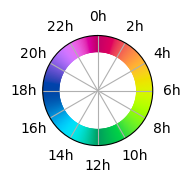

In [55]:
n = 512
φ = np.linspace(0,2*np.pi,n)
r = np.ones(n)

# plot hsv colors in polar coordinates
h = φ/(2*np.pi)
s = r/r.max()
v = np.ones(n)
#color = hsv_to_rgb_v(h,s,v)
color = p2lc(φ)


fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='polar')
for shift in np.arange(0,0.4,0.02):
    ax.scatter(x=φ,y=r+shift,c=color,s=.2,marker='o',rasterized=True)
#ax.scatter(x=φ,y=r,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.1,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.2,c=color,s=10*r,marker='o',alpha=1)
ax.grid('off')
ax.yaxis.set_visible(False)

ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])

# ---- mod here ---- #
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
# ---- mod here ---- #

fig.tight_layout()
fig.savefig('fig/kalman/Phase_color_wheel.pdf',bbox_inches='tight',dpi=300)
fig.savefig('fig/kalman/Phase_color_wheel.png',bbox_inches='tight',dpi=300)

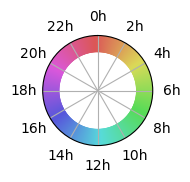

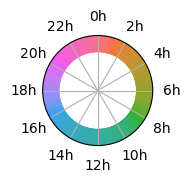

In [14]:
import seaborn as sns

n = 512
φ = np.linspace(0,2*np.pi,n)
r = np.ones(n)

# plot hsv colors in polar coordinates
h = φ/(2*np.pi)
s = r/r.max()
v = np.ones(n)

colors = sns.color_palette('hls',n_colors=512)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='polar')
for shift in np.arange(0,0.4,0.02):
    ax.scatter(x=φ,y=r+shift,c=colors,s=.2,marker='o',rasterized=True)
#ax.scatter(x=φ,y=r,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.1,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.2,c=color,s=10*r,marker='o',alpha=1)
ax.grid('off')
ax.yaxis.set_visible(False)

ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])

# ---- mod here ---- #
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
# ---- mod here ---- #

fig.tight_layout()

colors = sns.color_palette('husl',n_colors=512)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='polar')
for shift in np.arange(0,0.4,0.02):
    ax.scatter(x=φ,y=r+shift,c=colors,s=.2,marker='o',rasterized=True)
#ax.scatter(x=φ,y=r,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.1,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.2,c=color,s=10*r,marker='o',alpha=1)
ax.grid('off')
ax.yaxis.set_visible(False)

ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])

# ---- mod here ---- #
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
# ---- mod here ---- #

fig.tight_layout()

# EOF